# Modeling Notebook 

# ![Modeling Methods](images/presentation_assets/Modeling%20Method.png)

This notebook is meant to follow the [EDA notebook](eda.ipynb). In the previous notebook I preformed initial exploration and summary analysis of the data set being used in this project, as a well as formalizing the methods that will be used for evaluation. In this notebook I will build a convolutional neural network using the Python Keras API experimenting with various adjustments to find the best variation for this projects goals.

The prototype process will be as follows:  
- Begin with an initial [baseline model](#baseline-model)
- Experimenting with the [model architecture](#sophisticating-model-architecture)
- Experimenting with the [training protocol](#sophisticating-model-architecture)
- Testing various [regularization methods](#network-regularization)
- Testing various [optimization algorithms](#gradient-descent-optimization)

In [1]:
# dependencies for data preprocessing
import os
from keras.preprocessing.image import ImageDataGenerator

# dependencies for model compilation
from keras import layers
from keras import models
from keras import optimizers
from keras.metrics import Recall
from keras.regularizers import l2

# dependencies for model diagnostics
from sklearn.metrics import confusion_matrix, classification_report
import project_toolkit as ptk

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import numpy as np
import pandas as pd

# ![Data Source](images/presentation_assets/Data%20Overview.png)

## Data Preprocessing
Before modeling can begin the data must be formatted in a way that is readible to the model class object. This will follow the exact same preprocessing methods utilized in the previous [EDA notebook](eda.ipynb). Using the Keras ImageDataGenerator class ith the flow_from_directory() method, jpeg files from the subdirectory structure (according to the filepaths below) will be read into 4d arrays (batch index, image index, width, height). Images are set to grayscale so there will be only one colorchannel per image. 

In [2]:
# file paths to data directories
train_dir = "data/train/"
test_dir = "data/test/"
val_dir = "data/val/"

In [3]:
# instatiating a data degenerater for each split sample 
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
                                   
val_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
                       train_dir,
                       target_size=(150,150),
                       batch_size=16,
                       class_mode='binary',
                       color_mode='grayscale')

test_data_generator = test_datagen.flow_from_directory(
                      test_dir,
                      target_size=(150,150),
                      batch_size=16,
                      class_mode='binary',
                      color_mode='grayscale')

val_data_generator = val_datagen.flow_from_directory(
                     val_dir,
                     target_size=(150,150),
                     batch_size=16,
                     class_mode='binary',
                     color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Baseline Model
Beginning a convolutional neural network with the most simple architecture for the sake of efficient diagnostics and optimization.  
The architecture begins with a convolutional 2D layers, followed by a pooling layer, flattened, and then followed up with two dense layers.  
THe model is compiled using binary cross entropy to measure the loss function and accuracy foor the performance metric. The model is being trained so that it examens every training data point once; it is training on a single epochs in steps equivalent to the total number of batches.  

In [4]:
base_model = models.Sequential()
base_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
base_model.add(layers.MaxPooling2D((2, 2)))
base_model.add(layers.Flatten())
base_model.add(layers.Dense(512, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [5]:
base_model_results = base_model.fit(train_data_generator, 
                    batch_size=16,
                    epochs=1,
                    steps_per_epoch=326,
                    validation_data=test_data_generator,
                    validation_steps=39
                    )

326/326 [==============================] - 322s 988ms/step - loss: 0.6969 - acc: 0.8802 - recall: 0.9218 - val_loss: 0.8162 - val_acc: 0.7708 - val_recall: 0.9897


In [6]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               89719296  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 89,720,129
Trainable params: 89,720,129
Non-trainable params: 0
_________________________________________________________________


### Evaluate base model
Below I import the custom made project toolkit module and use it to generate performance statistics and diagnostic visualizations.

In [7]:
# this function shows a list of the functions available in the project toolkit module
ptk.toolkit_list()

['evaluate_model(model,data_generator)', 'viz_training_history(model_history,recall_num:None)', 'viz_class_balance_comparison(y_test,y_pred)', 'viz_confusion_matrix(confusion_matrix_array:np.array)']


In [8]:
# base_kpi is a tuple of (recall, loss)
# base_report is a sklearn classification report
# base_matrix is a confusion matrix as a 2d array
# base_labels is a tuple of (y_test, y_pred)
# other variables assigned with this function will follow these naming conventions througout the notebook <--- !!!

base_kpi, base_report, base_matrix, base_labels = ptk.evaluate_model(base_model,test_data_generator)
print(base_report)

20/20 [==============================] - 2s 113ms/step - loss: 0.8025 - acc: 0.7750 - recall: 0.9901
Done!
              precision    recall  f1-score   support

         0.0       0.96      0.41      0.57       237
         1.0       0.74      0.99      0.85       403

    accuracy                           0.78       640
   macro avg       0.85      0.70      0.71       640
weighted avg       0.82      0.78      0.75       640



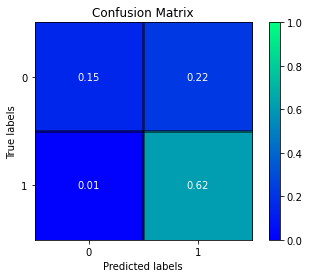

In [9]:
ptk.viz_confusion_matrix(base_matrix)

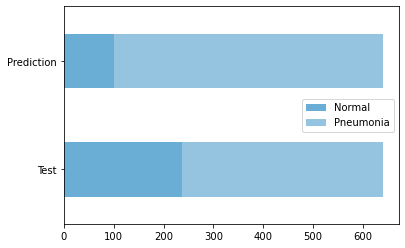

,Test,Prediction
Normal,237,101
Pneumonia,403,539


In [10]:
ptk.viz_class_balance_comparison(base_labels[0],base_labels[1])

The base model succesfully compiles and trains. The model is off to a decent start with a 1.0 recall, and F1 score of 0.81. Pneumonia is being correctly predicted every the time (i.e. 100% true positive rate), but at the cost of a lot of many false positives (normal being labeled pneumonia). The loss value is above 1.0 which is very high, if reduced the false positive rate should reduce also, the hat trick is to achieve this without negatively impacting F1 and recall scores beyond an acceptable range. In other words the model has a bias towards pneumonia and could be overfitting.

## Sophisticating model architecture  

The next step will be to expand the model architecture. This will multiply the parameters available to the model and therefore allow it to make higher order abstractions and discover less obvious connections within the features of the data. This will allow the model to label to behave with greater discernment. I will sophisticate the architecture by incorporating more layers of a variety of types including convolutional layers, pooling layers, and dense layers. However, the training protocol is the same as above.

In [11]:
deep_model = models.Sequential()

deep_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
deep_model.add(layers.MaxPooling2D((2, 2)))
deep_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
deep_model.add(layers.MaxPooling2D((2, 2)))
deep_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
deep_model.add(layers.MaxPooling2D((2, 2)))
deep_model.add(layers.Flatten())
deep_model.add(layers.Dense(512, activation='relu'))
deep_model.add(layers.Dense(256, activation='relu'))
deep_model.add(layers.Dense(1, activation='sigmoid'))

deep_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [12]:
deep_model_results = deep_model.fit(train_data_generator,
                              batch_size=16,
                              epochs=1,
                              steps_per_epoch=326,  
                              validation_data=test_data_generator, 
                              validation_steps=39)

326/326 [==============================] - 221s 678ms/step - loss: 0.3189 - acc: 0.8901 - recall_1: 0.9419 - val_loss: 0.7496 - val_acc: 0.7628 - val_recall_1: 0.9923


In [13]:
deep_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)            

### Evaluate deeper model architecture

In [14]:
deep_kpi, deep_report, deep_matrix, deep_labels = ptk.evaluate_model(deep_model,test_data_generator)
print(deep_report)

20/20 [==============================] - 3s 135ms/step - loss: 0.7541 - acc: 0.7625 - recall_1: 0.9925
Done!
              precision    recall  f1-score   support

         0.0       0.97      0.38      0.54       239
         1.0       0.73      0.99      0.84       401

    accuracy                           0.76       640
   macro avg       0.85      0.68      0.69       640
weighted avg       0.82      0.76      0.73       640



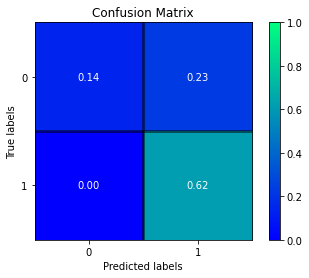

In [15]:
ptk.viz_confusion_matrix(deep_matrix)

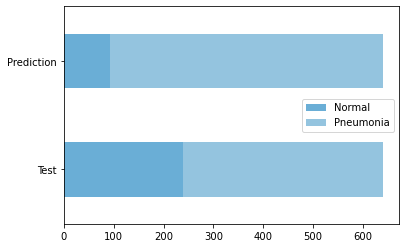

,Test,Prediction
Normal,239,93
Pneumonia,401,547


In [16]:
ptk.viz_class_balance_comparison(deep_labels[0],deep_labels[1])

With a more complex architecture has improved the model objectively speaking but not by a massive margin. Recall the KPI of my primary concern remains at a perfect 1.0, while F1 has improved from 0.81 to 0.84. Class balance of the predictions are closer to the true labels by about 34 observations. Essentially the model still has a biased towards Pneumonia, but less than the base model so its worth continuing with this architecture.

## sophisticating the training protocol
Below I will be testing various amounts of epochs where the steps per epoch are such that each data point is trained on only once.

#### training with 5 epochs

In [17]:
# the same model architecture as deep_model
five_epoch_model = models.Sequential()

five_epoch_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
five_epoch_model.add(layers.MaxPooling2D((2, 2)))
five_epoch_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
five_epoch_model.add(layers.MaxPooling2D((2, 2)))
five_epoch_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
five_epoch_model.add(layers.MaxPooling2D((2, 2)))
five_epoch_model.add(layers.Flatten())
five_epoch_model.add(layers.Dense(512, activation='relu'))
five_epoch_model.add(layers.Dense(256, activation='relu'))
five_epoch_model.add(layers.Dense(1, activation='sigmoid'))

five_epoch_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [19]:
five_epoch_model_results = five_epoch_model.fit(train_data_generator,
                                                batch_size=16,
                                                steps_per_epoch=66, 
                                                epochs=5, 
                                                validation_data=test_data_generator, 
                                                validation_steps=8)

Epoch 1/5
66/66 [==============================] - 34s 519ms/step - loss: 0.6064 - acc: 0.7462 - recall_2: 0.8859 - val_loss: 0.6279 - val_acc: 0.7500 - val_recall_2: 0.9762
Epoch 2/5
66/66 [==============================] - 33s 494ms/step - loss: 0.3040 - acc: 0.9015 - recall_2: 0.9442 - val_loss: 0.5272 - val_acc: 0.7969 - val_recall_2: 1.0000
Epoch 3/5
66/66 [==============================] - 46s 702ms/step - loss: 0.1991 - acc: 0.9366 - recall_2: 0.9574 - val_loss: 0.9241 - val_acc: 0.7578 - val_recall_2: 0.9759
Epoch 4/5
66/66 [==============================] - 48s 731ms/step - loss: 0.1967 - acc: 0.9318 - recall_2: 0.9600 - val_loss: 0.1858 - val_acc: 0.9141 - val_recall_2: 0.9643
Epoch 5/5
66/66 [==============================] - 37s 568ms/step - loss: 0.1545 - acc: 0.9460 - recall_2: 0.9663 - val_loss: 0.5187 - val_acc: 0.7812 - val_recall_2: 1.0000


In [20]:
five_epoch_kpi, five_epoch_report, five_epoch_matrix, five_epoch_labels = ptk.evaluate_model(five_epoch_model,test_data_generator)
print(five_epoch_report)

20/20 [==============================] - 3s 136ms/step - loss: 0.6886 - acc: 0.7812 - recall_2: 0.9900
Done!
              precision    recall  f1-score   support

         0.0       0.96      0.43      0.59       238
         1.0       0.75      0.99      0.85       402

    accuracy                           0.78       640
   macro avg       0.85      0.71      0.72       640
weighted avg       0.83      0.78      0.75       640



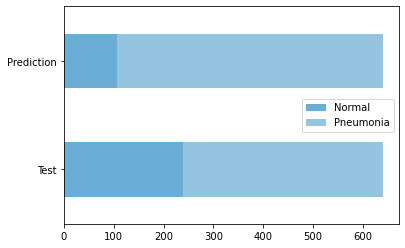

,Test,Prediction
Normal,238,106
Pneumonia,402,534


In [21]:
ptk.viz_class_balance_comparison(five_epoch_labels[0],five_epoch_labels[1])

#### Training with 10 epochs

In [22]:
# the same model architecture as deep_model
ten_epoch_model = models.Sequential()

ten_epoch_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
ten_epoch_model.add(layers.MaxPooling2D((2, 2)))
ten_epoch_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
ten_epoch_model.add(layers.MaxPooling2D((2, 2)))
ten_epoch_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
ten_epoch_model.add(layers.MaxPooling2D((2, 2)))
ten_epoch_model.add(layers.Flatten())
ten_epoch_model.add(layers.Dense(512, activation='relu'))
ten_epoch_model.add(layers.Dense(256, activation='relu'))
ten_epoch_model.add(layers.Dense(1, activation='sigmoid'))

ten_epoch_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [23]:
ten_epoch_model_results = ten_epoch_model.fit(train_data_generator,
                                        batch_size=16,
                                        steps_per_epoch=33, 
                                        epochs=10, 
                                        validation_data=test_data_generator, 
                                        validation_steps=4)

Epoch 1/10
33/33 [==============================] - 17s 521ms/step - loss: 0.8422 - acc: 0.7348 - recall_3: 0.9383 - val_loss: 0.8147 - val_acc: 0.6406 - val_recall_3: 1.0000
Epoch 2/10
33/33 [==============================] - 16s 499ms/step - loss: 0.5541 - acc: 0.7595 - recall_3: 0.8663 - val_loss: 0.6192 - val_acc: 0.7031 - val_recall_3: 0.9487
Epoch 3/10
33/33 [==============================] - 18s 545ms/step - loss: 0.3254 - acc: 0.8769 - recall_3: 0.9058 - val_loss: 0.3695 - val_acc: 0.8281 - val_recall_3: 0.9767
Epoch 4/10
33/33 [==============================] - 18s 546ms/step - loss: 0.2199 - acc: 0.9186 - recall_3: 0.9368 - val_loss: 0.7313 - val_acc: 0.6875 - val_recall_3: 1.0000
Epoch 5/10
33/33 [==============================] - 18s 558ms/step - loss: 0.2272 - acc: 0.9223 - recall_3: 0.9543 - val_loss: 1.4637 - val_acc: 0.7344 - val_recall_3: 1.0000
Epoch 6/10
33/33 [==============================] - 19s 587ms/step - loss: 0.1682 - acc: 0.9413 - recall_3: 0.9647 - val_loss

The accuracy and loss on training data is begining to behave more as desired; however on the test data the history is still quite eratic indicating that the model is still overfitting and not able to generalize consistently. All that considered the final accuracy on the training data is the best so far so we're moving in the right direction.

In [24]:
ten_epoch_kpi, ten_epoch_report, ten_epoch_matrix, ten_epoch_labels = ptk.evaluate_model(ten_epoch_model,test_data_generator)
print(ten_epoch_report)

20/20 [==============================] - 6s 297ms/step - loss: 0.7852 - acc: 0.7547 - recall_3: 0.9950
Done!
              precision    recall  f1-score   support

         0.0       0.98      0.35      0.52       240
         1.0       0.72      0.99      0.84       400

    accuracy                           0.75       640
   macro avg       0.85      0.67      0.68       640
weighted avg       0.82      0.75      0.72       640



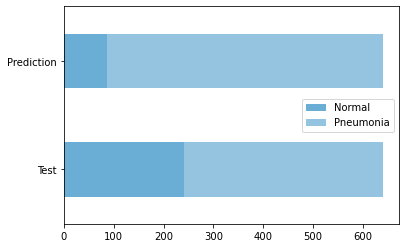

,Test,Prediction
Normal,240,87
Pneumonia,400,553


In [25]:
ptk.viz_class_balance_comparison(ten_epoch_labels[0],ten_epoch_labels[1])

#### Training with 15 epochs

In [26]:
# the same model architecture as deep_model
fifteen_epoch_model = models.Sequential()

fifteen_epoch_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
fifteen_epoch_model.add(layers.MaxPooling2D((2, 2)))
fifteen_epoch_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
fifteen_epoch_model.add(layers.MaxPooling2D((2, 2)))
fifteen_epoch_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
fifteen_epoch_model.add(layers.MaxPooling2D((2, 2)))
fifteen_epoch_model.add(layers.Flatten())
fifteen_epoch_model.add(layers.Dense(512, activation='relu'))
fifteen_epoch_model.add(layers.Dense(256, activation='relu'))
fifteen_epoch_model.add(layers.Dense(1, activation='sigmoid'))

fifteen_epoch_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [27]:
fifteen_epoch_model_results = fifteen_epoch_model.fit(train_data_generator,
                                        batch_size=16,
                                        steps_per_epoch=22, 
                                        epochs=15, 
                                        validation_data=test_data_generator, 
                                        validation_steps=3)

Epoch 1/15
22/22 [==============================] - 16s 707ms/step - loss: 1.3193 - acc: 0.7017 - recall_4: 0.9023 - val_loss: 0.6923 - val_acc: 0.4792 - val_recall_4: 1.0000
Epoch 2/15
22/22 [==============================] - 14s 616ms/step - loss: 0.7110 - acc: 0.7557 - recall_4: 0.9514 - val_loss: 0.5173 - val_acc: 0.7083 - val_recall_4: 0.9310
Epoch 3/15
22/22 [==============================] - 13s 592ms/step - loss: 0.3679 - acc: 0.8750 - recall_4: 0.9436 - val_loss: 0.4801 - val_acc: 0.7917 - val_recall_4: 0.8276
Epoch 4/15
22/22 [==============================] - 13s 611ms/step - loss: 0.3225 - acc: 0.8750 - recall_4: 0.9249 - val_loss: 0.7460 - val_acc: 0.7083 - val_recall_4: 0.8966
Epoch 5/15
22/22 [==============================] - 14s 623ms/step - loss: 0.2264 - acc: 0.9205 - recall_4: 0.9377 - val_loss: 1.2706 - val_acc: 0.6667 - val_recall_4: 1.0000
Epoch 6/15
22/22 [==============================] - 14s 658ms/step - loss: 0.2969 - acc: 0.8949 - recall_4: 0.9288 - val_loss

In [28]:
fifteen_epoch_kpi, fifteen_epoch_report, fifteen_epoch_matrix, fifteen_epoch_labels = ptk.evaluate_model(fifteen_epoch_model,test_data_generator)
print(fifteen_epoch_report)

20/20 [==============================] - 3s 134ms/step - loss: 0.8758 - acc: 0.7531 - recall_4: 0.9950
Done!
              precision    recall  f1-score   support

         0.0       0.98      0.35      0.51       239
         1.0       0.72      1.00      0.83       401

    accuracy                           0.75       640
   macro avg       0.85      0.67      0.67       640
weighted avg       0.82      0.75      0.71       640



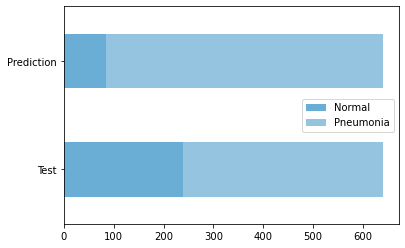

,Test,Prediction
Normal,239,85
Pneumonia,401,555


In [29]:
ptk.viz_class_balance_comparison(fifteen_epoch_labels[0],fifteen_epoch_labels[1])

#### Training with 20 epochs

In [30]:
# the same model architecture as deep_model
twenty_epoch_model = models.Sequential()

twenty_epoch_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
twenty_epoch_model.add(layers.MaxPooling2D((2, 2)))
twenty_epoch_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
twenty_epoch_model.add(layers.MaxPooling2D((2, 2)))
twenty_epoch_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
twenty_epoch_model.add(layers.MaxPooling2D((2, 2)))
twenty_epoch_model.add(layers.Flatten())
twenty_epoch_model.add(layers.Dense(512, activation='relu'))
twenty_epoch_model.add(layers.Dense(256, activation='relu'))
twenty_epoch_model.add(layers.Dense(1, activation='sigmoid'))

twenty_epoch_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [31]:
twenty_epoch_model_results = twenty_epoch_model.fit(train_data_generator,
                                        batch_size=16,
                                        steps_per_epoch=16, 
                                        epochs=20, 
                                        validation_data=test_data_generator, 
                                        validation_steps=3)

Epoch 1/20
16/16 [==============================] - 8s 530ms/step - loss: 0.8583 - acc: 0.6719 - recall_5: 0.8235 - val_loss: 0.6621 - val_acc: 0.6667 - val_recall_5: 1.0000
Epoch 2/20
16/16 [==============================] - 8s 506ms/step - loss: 0.5865 - acc: 0.7578 - recall_5: 0.9144 - val_loss: 0.8802 - val_acc: 0.5833 - val_recall_5: 1.0000
Epoch 3/20
16/16 [==============================] - 8s 480ms/step - loss: 0.4416 - acc: 0.8203 - recall_5: 0.9109 - val_loss: 0.8853 - val_acc: 0.5208 - val_recall_5: 1.0000
Epoch 4/20
16/16 [==============================] - 8s 502ms/step - loss: 0.3845 - acc: 0.8477 - recall_5: 0.9471 - val_loss: 0.5022 - val_acc: 0.8958 - val_recall_5: 0.9688
Epoch 5/20
16/16 [==============================] - 8s 490ms/step - loss: 0.3616 - acc: 0.8438 - recall_5: 0.9137 - val_loss: 1.3400 - val_acc: 0.6458 - val_recall_5: 1.0000
Epoch 6/20
16/16 [==============================] - 8s 500ms/step - loss: 0.3243 - acc: 0.8750 - recall_5: 0.9326 - val_loss: 0.45

In [32]:
twenty_epoch_kpi, twenty_epoch_report, twenty_epoch_matrix, twenty_epoch_labels = ptk.evaluate_model(twenty_epoch_model,test_data_generator)
print(twenty_epoch_report)

20/20 [==============================] - 3s 135ms/step - loss: 0.9796 - acc: 0.7234 - recall_5: 0.9975
Done!
              precision    recall  f1-score   support

         0.0       0.99      0.27      0.43       242
         1.0       0.69      1.00      0.82       398

    accuracy                           0.72       640
   macro avg       0.84      0.64      0.62       640
weighted avg       0.80      0.72      0.67       640



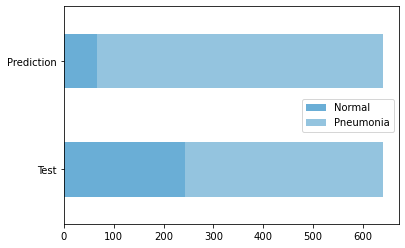

,Test,Prediction
Normal,242,67
Pneumonia,398,573


In [33]:
ptk.viz_class_balance_comparison(twenty_epoch_labels[0],twenty_epoch_labels[1])

#### Training with 25 epochs

In [34]:
# the same model architecture as deep_model
twentyFive_epoch_model = models.Sequential()

twentyFive_epoch_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
twentyFive_epoch_model.add(layers.MaxPooling2D((2, 2)))
twentyFive_epoch_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
twentyFive_epoch_model.add(layers.MaxPooling2D((2, 2)))
twentyFive_epoch_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
twentyFive_epoch_model.add(layers.MaxPooling2D((2, 2)))
twentyFive_epoch_model.add(layers.Flatten())
twentyFive_epoch_model.add(layers.Dense(512, activation='relu'))
twentyFive_epoch_model.add(layers.Dense(256, activation='relu'))
twentyFive_epoch_model.add(layers.Dense(1, activation='sigmoid'))

twentyFive_epoch_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [35]:
twentyFive_epoch_model_results = twentyFive_epoch_model.fit(train_data_generator, 
                                        steps_per_epoch=13, 
                                        epochs=25, 
                                        validation_data=test_data_generator, 
                                        validation_steps=2)

Epoch 1/25
13/13 [==============================] - 9s 723ms/step - loss: 0.9753 - acc: 0.7500 - recall_6: 0.9268 - val_loss: 0.7972 - val_acc: 0.6250 - val_recall_6: 1.0000
Epoch 2/25
13/13 [==============================] - 6s 499ms/step - loss: 0.6322 - acc: 0.6875 - recall_6: 0.8725 - val_loss: 0.5429 - val_acc: 0.7500 - val_recall_6: 1.0000
Epoch 3/25
13/13 [==============================] - 7s 505ms/step - loss: 0.5265 - acc: 0.7740 - recall_6: 0.9809 - val_loss: 0.4242 - val_acc: 0.9062 - val_recall_6: 0.9130
Epoch 4/25
13/13 [==============================] - 6s 480ms/step - loss: 0.4661 - acc: 0.7788 - recall_6: 0.8591 - val_loss: 2.0020 - val_acc: 0.5938 - val_recall_6: 1.0000
Epoch 5/25
13/13 [==============================] - 6s 470ms/step - loss: 0.5794 - acc: 0.8413 - recall_6: 0.9490 - val_loss: 1.0382 - val_acc: 0.6562 - val_recall_6: 1.0000
Epoch 6/25
13/13 [==============================] - 7s 518ms/step - loss: 0.3376 - acc: 0.8606 - recall_6: 0.9308 - val_loss: 0.62

In [36]:
twentyFive_epoch_kpi, twentyFive_epoch_report, twentyFive_epoch_matrix, twentyFive_epoch_labels = ptk.evaluate_model(twentyFive_epoch_model,test_data_generator)
print(twentyFive_epoch_report)

20/20 [==============================] - 3s 134ms/step - loss: 1.7958 - acc: 0.7156 - recall_6: 0.9975
Done!
              precision    recall  f1-score   support

         0.0       0.98      0.25      0.40       241
         1.0       0.69      1.00      0.81       399

    accuracy                           0.72       640
   macro avg       0.84      0.62      0.61       640
weighted avg       0.80      0.72      0.66       640



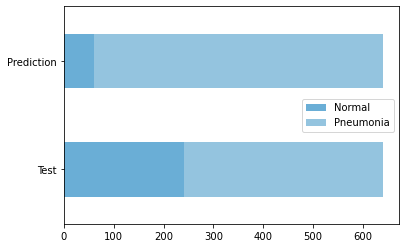

,Test,Prediction
Normal,241,61
Pneumonia,399,579


In [37]:
ptk.viz_class_balance_comparison(twentyFive_epoch_labels[0],twentyFive_epoch_labels[1])

#### Visualizing training histroy for different epoch counts

FIVE EPOCHS


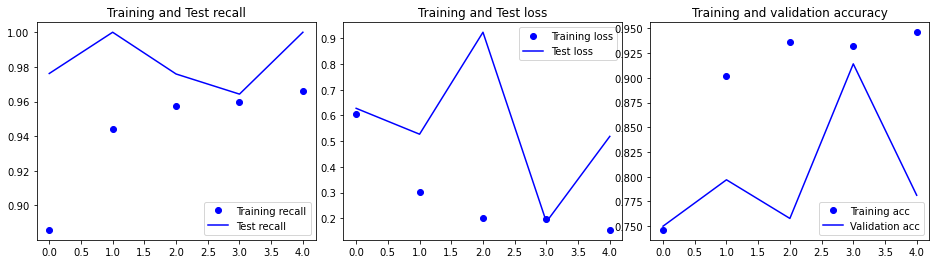

In [39]:
print("FIVE EPOCHS")
ptk.viz_training_history(five_epoch_model_results,recall_num="_2")

TEN EPOCHS


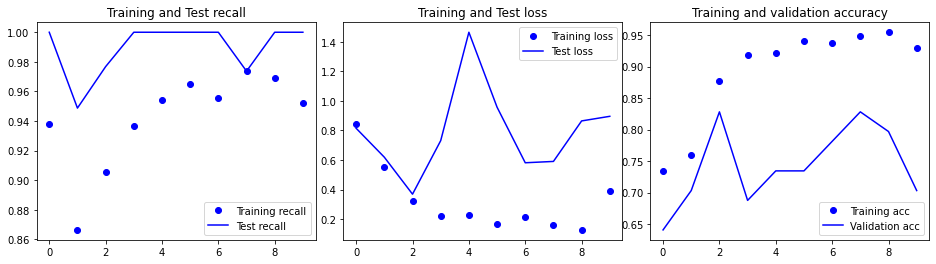

In [40]:
print("TEN EPOCHS")
ptk.viz_training_history(ten_epoch_model_results,recall_num="_3")

15 EPOCHS


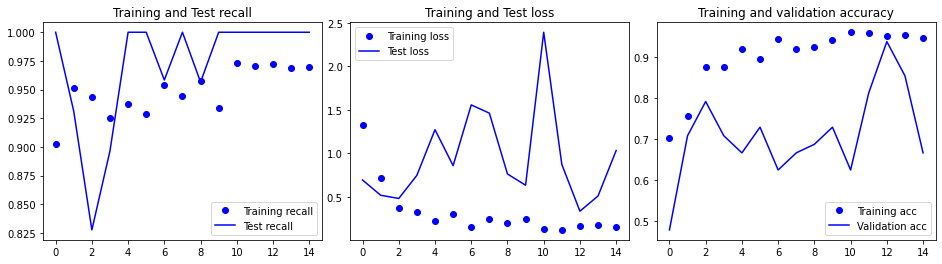

In [41]:
print("15 EPOCHS")
ptk.viz_training_history(fifteen_epoch_model_results,recall_num="_4")

20 EPOCHS


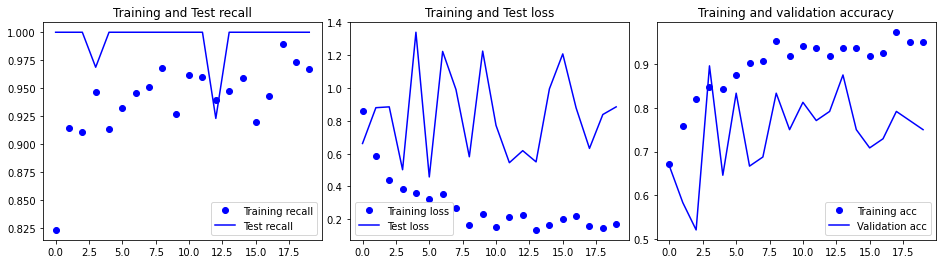

In [42]:
print("20 EPOCHS")
ptk.viz_training_history(twenty_epoch_model_results,recall_num="_5")

25 EPOCHS


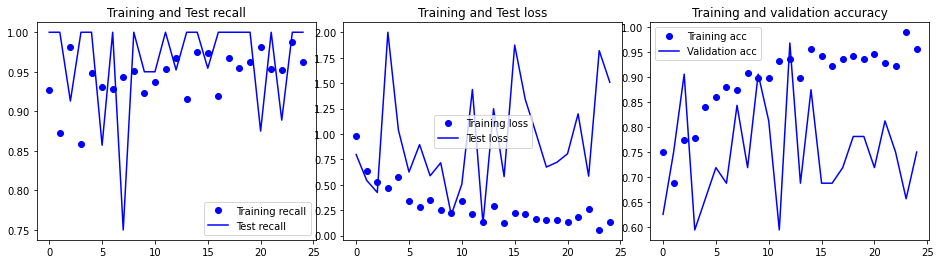

In [43]:
print("25 EPOCHS")
ptk.viz_training_history(twentyFive_epoch_model_results,recall_num="_6")

Its my analysis that 15 epochs is the best of the versions tested above because the recall is as good as all the other versions, it has the best F1 score of the group, and the class balance of its predictions is the closest to that of the true class balance of the test labels. So I will be moving forward with network regularization with the model architecture and training protocol of the fifteen_epoch_model

## Network Regularization

### L2 regularization
I will begin regularizing the network by incorporating L2 regularization on the dense layers of the existing model architecture

In [44]:
# the same model architecture as deep_model and fifteen_epoch_model
# except the added L2 regularization in the last two dense hidden layers
L2_model = models.Sequential()

L2_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
L2_model.add(layers.MaxPooling2D((2, 2)))
L2_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
L2_model.add(layers.MaxPooling2D((2, 2)))
L2_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
L2_model.add(layers.MaxPooling2D((2, 2)))
L2_model.add(layers.Flatten())
L2_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.0005)))
L2_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
L2_model.add(layers.Dense(1, activation='sigmoid'))

L2_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [45]:
# the same training protocol as the fifteen_epoch_model
L2_model_results = L2_model.fit(train_data_generator,
                                        batch_size=16,
                                        steps_per_epoch=22, 
                                        epochs=15, 
                                        validation_data=test_data_generator, 
                                        validation_steps=3)

Epoch 1/15
22/22 [==============================] - 13s 591ms/step - loss: 2.3267 - acc: 0.6875 - recall_7: 0.9008 - val_loss: 1.7175 - val_acc: 0.6667 - val_recall_7: 1.0000
Epoch 2/15
22/22 [==============================] - 12s 544ms/step - loss: 1.3025 - acc: 0.7131 - recall_7: 0.9154 - val_loss: 1.1898 - val_acc: 0.5417 - val_recall_7: 1.0000
Epoch 3/15
22/22 [==============================] - 12s 540ms/step - loss: 1.0142 - acc: 0.7955 - recall_7: 0.9432 - val_loss: 0.8169 - val_acc: 0.7292 - val_recall_7: 1.0000
Epoch 4/15
22/22 [==============================] - 12s 545ms/step - loss: 0.6952 - acc: 0.8352 - recall_7: 0.9213 - val_loss: 0.6666 - val_acc: 0.7917 - val_recall_7: 1.0000
Epoch 5/15
22/22 [==============================] - 13s 572ms/step - loss: 0.5539 - acc: 0.9119 - recall_7: 0.9542 - val_loss: 0.5664 - val_acc: 0.8125 - val_recall_7: 1.0000
Epoch 6/15
22/22 [==============================] - 13s 598ms/step - loss: 0.4694 - acc: 0.8949 - recall_7: 0.9318 - val_loss

In [46]:
L2_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 36992)            

In [47]:
L2_kpi, L2_report, L2_matrix, L2_labels = ptk.evaluate_model(L2_model,test_data_generator)
print(L2_report)

20/20 [==============================] - 3s 151ms/step - loss: 0.7510 - acc: 0.7672 - recall_7: 0.9950
Done!
              precision    recall  f1-score   support

         0.0       0.98      0.38      0.55       239
         1.0       0.73      1.00      0.84       401

    accuracy                           0.77       640
   macro avg       0.85      0.69      0.70       640
weighted avg       0.82      0.77      0.73       640



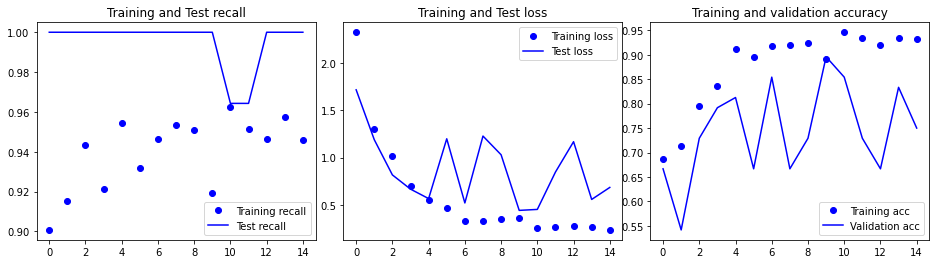

In [49]:
ptk.viz_training_history(L2_model_results,recall_num="_7")

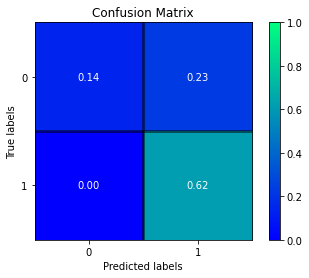

In [50]:
ptk.viz_confusion_matrix(L2_matrix)

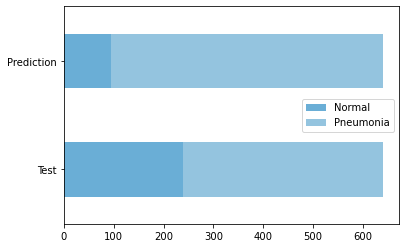

,Test,Prediction
Normal,239,94
Pneumonia,401,546


In [51]:
ptk.viz_class_balance_comparison(L2_labels[0],L2_labels[1])

After testing various weights for the kernal regulizer parameters in the two hidden dense layers, it is clear the in the first 0.0005 and in the second 0.005 is far and above the best configuration. Its yields even the best model so far in the project. The recall and F1 score are still in acceptable ranges, and the class balance of the predicted labels is the closest to the true labels that it has been so far, indicating this has greatly alleviated any overfitting or bias present in the model. 

For the sake of readibility I have not shown every single variation test as it would make this notebook untenable to even the most dutiful data scientist so I will list below the variations tested.

All of the following performed more or less the same as every previous model tested in terms of KPIs and prediction labels class balance
-   .005, .005
-   .0005, .0005
-   .05, .05
-   .005, .05

This configuration sacrifices some recall and F1 performance, but only slightly and in return is the most accurate model yet indicating it is the most properly fit so far(i.e. not overfit)
-   .0005, .005

### Dropout regularization
The most common practice with dropout regularization of CNNs is including a dropout layer after each fully connected (Dense) layer. So the next step will be adding two dropout layers each with a value of 0.3, after each of the two hidden Dense layers. There will be no dropout incorporated with the output layer.

In [52]:
# the same model architecture as the L2 Model except for the addition of dropout layers between the two hidden dense layers
dropout_model = models.Sequential()

dropout_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Flatten())
dropout_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.0005)))
dropout_model.add(layers.Dropout(0.05))
dropout_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
dropout_model.add(layers.Dropout(0.01))
dropout_model.add(layers.Dense(1, activation='sigmoid'))

dropout_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [53]:
# the same training protocol as the fifteen_epoch_model
dropout_model_results = dropout_model.fit(train_data_generator,
                                        batch_size=16,
                                        steps_per_epoch=22, 
                                        epochs=15, 
                                        validation_data=test_data_generator, 
                                        validation_steps=3)

Epoch 1/15
22/22 [==============================] - 13s 600ms/step - loss: 2.3182 - acc: 0.6733 - recall_8: 0.8308 - val_loss: 1.5432 - val_acc: 0.6458 - val_recall_8: 1.0000
Epoch 2/15
22/22 [==============================] - 13s 570ms/step - loss: 1.2676 - acc: 0.7386 - recall_8: 0.9222 - val_loss: 1.2132 - val_acc: 0.6458 - val_recall_8: 0.9655
Epoch 3/15
22/22 [==============================] - 15s 660ms/step - loss: 0.8877 - acc: 0.8125 - recall_8: 0.8622 - val_loss: 1.3739 - val_acc: 0.6667 - val_recall_8: 1.0000
Epoch 4/15
22/22 [==============================] - 15s 660ms/step - loss: 0.6526 - acc: 0.8693 - recall_8: 0.9173 - val_loss: 1.1398 - val_acc: 0.6458 - val_recall_8: 0.9677
Epoch 5/15
22/22 [==============================] - 15s 679ms/step - loss: 0.5033 - acc: 0.8977 - recall_8: 0.9237 - val_loss: 0.6788 - val_acc: 0.8125 - val_recall_8: 0.9655
Epoch 6/15
22/22 [==============================] - 15s 701ms/step - loss: 0.4091 - acc: 0.9006 - recall_8: 0.9432 - val_loss

In [54]:
dropout_kpi, dropout_report, dropout_matrix, dropout_labels = ptk.evaluate_model(dropout_model,test_data_generator)
print(dropout_report)

20/20 [==============================] - 6s 293ms/step - loss: 0.7724 - acc: 0.8078 - recall_8: 0.9774
Done!
              precision    recall  f1-score   support

         0.0       0.93      0.53      0.67       241
         1.0       0.77      0.98      0.86       399

    accuracy                           0.81       640
   macro avg       0.85      0.75      0.77       640
weighted avg       0.83      0.81      0.79       640



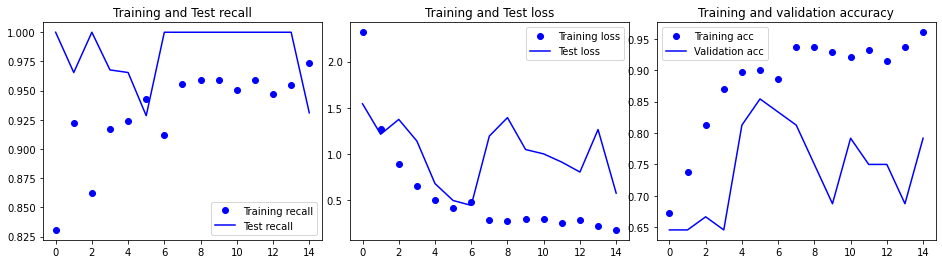

In [55]:
ptk.viz_training_history(dropout_model_results,recall_num="_8")

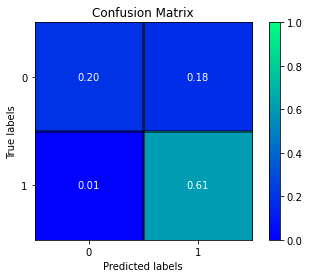

In [56]:
ptk.viz_confusion_matrix(dropout_matrix)

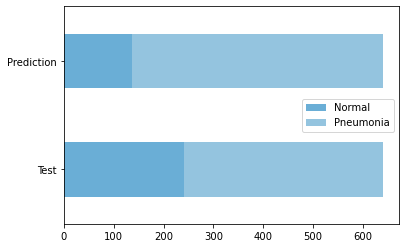

,Test,Prediction
Normal,241,136
Pneumonia,399,504


In [57]:
ptk.viz_class_balance_comparison(dropout_labels[0],dropout_labels[1])

I've experimented with various configurations (different values in two different dropout layers). Dropping out on a gradient (less dropout in the first and more in the second) seems to be the models preference. The best configuration I've found is 0.05 in the first dropout followed by 0.1 in the second. This model yields the best performance of all the dropout configurations, and is competitive with the best models tested so far. I will be proceeding using this dropout configuration.

## Gradient Descent Optimization
So far, a optimizer has not been specified in the model compiler. Below I will test 3 different optimization algorithms to discover if gradient descent optimization is need at all and if so which algorithm is best suited for the current model. I have selected these three algorithms for experimentation based on qualitative research on what algorithms are best suited for binary classification in the context of a neural network. 

The optimizers being test are:
- Stochastic Gradient Descent (SGD)
- Adaptive Moment Estimation (Adam)
- Adaptive Delta (Adadelta)

#### SGD optimization

In [58]:
# the same model architecture as the L2_model
SGD_model = models.Sequential()

SGD_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
SGD_model.add(layers.MaxPooling2D((2, 2)))
SGD_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
SGD_model.add(layers.MaxPooling2D((2, 2)))
SGD_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
SGD_model.add(layers.MaxPooling2D((2, 2)))
SGD_model.add(layers.Flatten())
SGD_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.0005)))
# SGD_model.add(layers.Dropout(0.05))
SGD_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
# SGD_model.add(layers.Dropout(0.01))
SGD_model.add(layers.Dense(1, activation='sigmoid'))

SGD_model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['acc',Recall()])


In [59]:
# the same training protocol as the fifteen_epoch_model and L2_model
SGD_model_results = SGD_model.fit(train_data_generator,
                                        batch_size=16,
                                        steps_per_epoch=22, 
                                        epochs=15, 
                                        validation_data=test_data_generator, 
                                        validation_steps=3)

Epoch 1/15
22/22 [==============================] - 11s 489ms/step - loss: 2.8052 - acc: 0.7670 - recall_9: 1.0000 - val_loss: 2.9463 - val_acc: 0.5833 - val_recall_9: 1.0000
Epoch 2/15
22/22 [==============================] - 11s 508ms/step - loss: 2.7974 - acc: 0.7273 - recall_9: 1.0000 - val_loss: 2.9399 - val_acc: 0.5417 - val_recall_9: 1.0000
Epoch 3/15
22/22 [==============================] - 12s 532ms/step - loss: 2.7807 - acc: 0.7330 - recall_9: 1.0000 - val_loss: 2.8863 - val_acc: 0.6042 - val_recall_9: 1.0000
Epoch 4/15
22/22 [==============================] - 12s 523ms/step - loss: 2.7537 - acc: 0.7443 - recall_9: 1.0000 - val_loss: 2.8953 - val_acc: 0.6042 - val_recall_9: 1.0000
Epoch 5/15
22/22 [==============================] - 12s 528ms/step - loss: 2.7642 - acc: 0.7131 - recall_9: 1.0000 - val_loss: 2.7784 - val_acc: 0.6875 - val_recall_9: 1.0000
Epoch 6/15
22/22 [==============================] - 12s 557ms/step - loss: 2.7568 - acc: 0.7045 - recall_9: 1.0000 - val_loss

In [60]:
SGD_kpi, SGD_report, SGD_matrix, SGD_labels = ptk.evaluate_model(SGD_model,test_data_generator)
print(SGD_report)

20/20 [==============================] - 3s 155ms/step - loss: 2.7185 - acc: 0.6641 - recall_9: 0.9975
Done!
              precision    recall  f1-score   support

         0.0       0.97      0.12      0.21       243
         1.0       0.65      1.00      0.79       397

    accuracy                           0.66       640
   macro avg       0.81      0.56      0.50       640
weighted avg       0.77      0.66      0.57       640



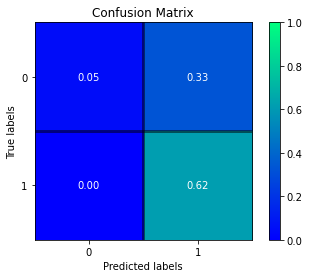

In [61]:
ptk.viz_confusion_matrix(SGD_matrix)

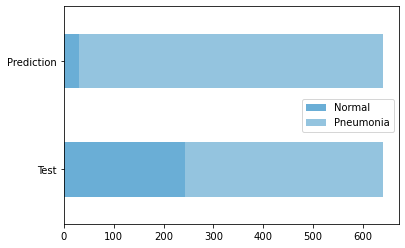

,Test,Prediction
Normal,243,30
Pneumonia,397,610


In [62]:
ptk.viz_class_balance_comparison(SGD_labels[0],SGD_labels[1])

#### Adam Optimization

In [63]:
# the same model architecture as the L2_model
Adam_model = models.Sequential()

Adam_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
Adam_model.add(layers.MaxPooling2D((2, 2)))
Adam_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
Adam_model.add(layers.MaxPooling2D((2, 2)))
Adam_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
Adam_model.add(layers.MaxPooling2D((2, 2)))
Adam_model.add(layers.Flatten())
Adam_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.0005)))
Adam_model.add(layers.Dropout(0.05))
Adam_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
Adam_model.add(layers.Dropout(0.01))
Adam_model.add(layers.Dense(1, activation='sigmoid'))

Adam_model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['acc',Recall()])


In [64]:
# the same training protocol as the fifteen_epoch_model and L2_model
Adam_model_results = Adam_model.fit(train_data_generator,
                                        batch_size=16,
                                        steps_per_epoch=22, 
                                        epochs=15, 
                                        validation_data=test_data_generator, 
                                        validation_steps=3)

Epoch 1/15
22/22 [==============================] - 12s 541ms/step - loss: 2.2222 - acc: 0.6619 - recall_10: 0.8785 - val_loss: 1.7588 - val_acc: 0.5417 - val_recall_10: 1.0000
Epoch 2/15
22/22 [==============================] - 11s 485ms/step - loss: 1.3116 - acc: 0.7926 - recall_10: 0.9708 - val_loss: 1.4721 - val_acc: 0.6042 - val_recall_10: 1.0000
Epoch 3/15
22/22 [==============================] - 11s 499ms/step - loss: 0.8334 - acc: 0.8608 - recall_10: 0.9262 - val_loss: 1.4711 - val_acc: 0.5833 - val_recall_10: 1.0000
Epoch 4/15
22/22 [==============================] - 10s 471ms/step - loss: 0.5305 - acc: 0.9318 - recall_10: 0.9642 - val_loss: 0.8470 - val_acc: 0.7917 - val_recall_10: 1.0000
Epoch 5/15
22/22 [==============================] - 11s 486ms/step - loss: 0.4924 - acc: 0.9119 - recall_10: 0.9474 - val_loss: 0.8295 - val_acc: 0.7500 - val_recall_10: 1.0000
Epoch 6/15
22/22 [==============================] - 11s 484ms/step - loss: 0.3759 - acc: 0.9233 - recall_10: 0.9624

In [65]:
Adam_kpi, Adam_report, Adam_matrix, Adam_labels = ptk.evaluate_model(Adam_model,test_data_generator)
print(Adam_report)

20/20 [==============================] - 3s 157ms/step - loss: 0.7222 - acc: 0.7609 - recall_10: 0.9874
Done!
              precision    recall  f1-score   support

         0.0       0.95      0.39      0.55       243
         1.0       0.73      0.99      0.84       397

    accuracy                           0.76       640
   macro avg       0.84      0.69      0.70       640
weighted avg       0.81      0.76      0.73       640



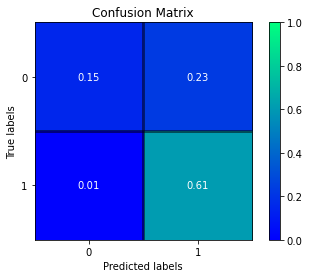

In [66]:
ptk.viz_confusion_matrix(Adam_matrix)

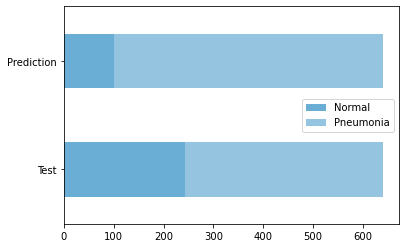

,Test,Prediction
Normal,243,100
Pneumonia,397,540


In [67]:
ptk.viz_class_balance_comparison(Adam_labels[0],Adam_labels[1])

#### Adadelta Optimization

In [68]:
# the same model architecture as the L2_model
Adadelta_model = models.Sequential()

Adadelta_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
Adadelta_model.add(layers.MaxPooling2D((2, 2)))
Adadelta_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
Adadelta_model.add(layers.MaxPooling2D((2, 2)))
Adadelta_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
Adadelta_model.add(layers.MaxPooling2D((2, 2)))
Adadelta_model.add(layers.Flatten())
Adadelta_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.0005)))
Adadelta_model.add(layers.Dropout(0.05))
Adadelta_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
Adadelta_model.add(layers.Dropout(0.01))
Adadelta_model.add(layers.Dense(1, activation='sigmoid'))

Adadelta_model.compile(optimizer='Adadelta',
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
                )


In [69]:
# the same training protocol as the fifteen_epoch_model and L2_model
Adadelta_model_results = Adadelta_model.fit(train_data_generator,
                                        batch_size=16,
                                        steps_per_epoch=22, 
                                        epochs=15, 
                                        validation_data=test_data_generator, 
                                        validation_steps=3)

Epoch 1/15
22/22 [==============================] - 12s 524ms/step - loss: 2.8916 - acc: 0.7386 - recall_11: 0.9962 - val_loss: 2.8953 - val_acc: 0.6042 - val_recall_11: 1.0000
Epoch 2/15
22/22 [==============================] - 11s 490ms/step - loss: 2.8770 - acc: 0.7301 - recall_11: 1.0000 - val_loss: 2.8880 - val_acc: 0.6250 - val_recall_11: 1.0000
Epoch 3/15
22/22 [==============================] - 11s 489ms/step - loss: 2.8652 - acc: 0.7358 - recall_11: 1.0000 - val_loss: 2.8838 - val_acc: 0.6250 - val_recall_11: 1.0000
Epoch 4/15
22/22 [==============================] - 12s 523ms/step - loss: 2.8556 - acc: 0.7386 - recall_11: 1.0000 - val_loss: 2.8612 - val_acc: 0.6875 - val_recall_11: 1.0000
Epoch 5/15
22/22 [==============================] - 12s 546ms/step - loss: 2.8374 - acc: 0.7642 - recall_11: 1.0000 - val_loss: 2.8591 - val_acc: 0.6875 - val_recall_11: 1.0000
Epoch 6/15
22/22 [==============================] - 12s 567ms/step - loss: 2.8366 - acc: 0.7358 - recall_11: 1.0000

In [70]:
Adadelta_kpi, Adadelta_report, Adadelta_matrix, Adadelta_labels = ptk.evaluate_model(Adadelta_model,test_data_generator)
print(Adadelta_report)

20/20 [==============================] - 3s 159ms/step - loss: 2.8729 - acc: 0.6250 - recall_11: 1.0000
Done!
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       240
         1.0       0.62      1.00      0.77       400

    accuracy                           0.62       640
   macro avg       0.31      0.50      0.38       640
weighted avg       0.39      0.62      0.48       640



c:\Users\zethu\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


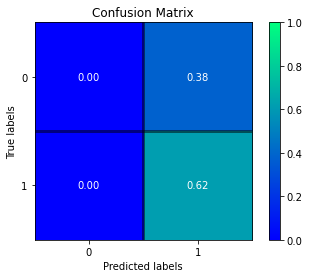

In [71]:
ptk.viz_confusion_matrix(Adadelta_matrix)

The following plot is showing some very odd behaviour, the prediction bar has a total volume, double that ofthe actuall predictions made. I've ran the source code for this function in this notebook and discovered that this model was predicting pneumonia every single time. Under the hood pandas is used render this plot, and the 50/50 distribution and doubled volume seems to be an artifact of pandas reusing the single array element because there is not a second one. 

In other words the Adadelta algorithm its severely overfitting the model and not fit for use. 

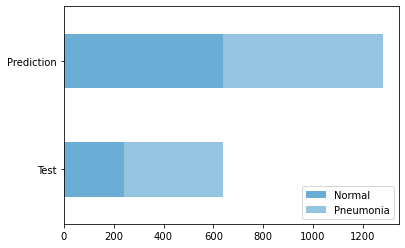

,Test,Prediction
Normal,240,640
Pneumonia,400,640


In [72]:
ptk.viz_class_balance_comparison(Adadelta_labels[0], Adadelta_labels[1])

#### Visualizing training history for various optimizations

SGD training history


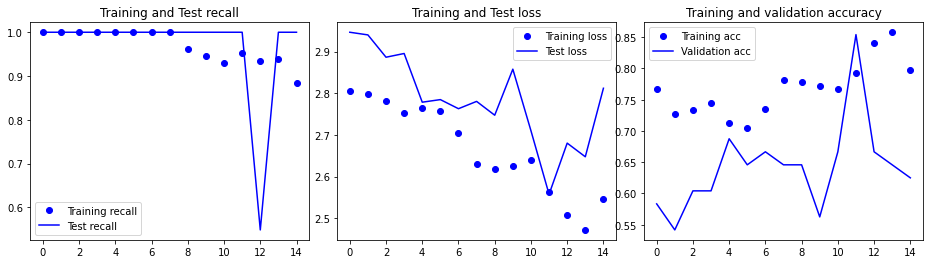

In [73]:
print("SGD training history")
ptk.viz_training_history(SGD_model_results,recall_num="_9")

Adam training history


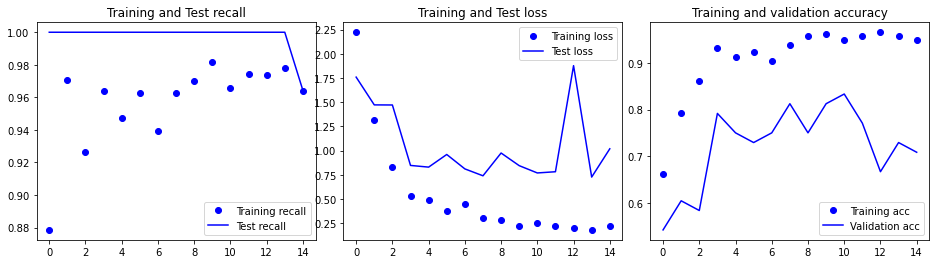

In [74]:
print("Adam training history")
ptk.viz_training_history(Adam_model_results,recall_num="_10")

On all counts the Adam optimization performs the best. Adadelta wildy overfits so its not even under consideration. Whereas Adam's recall appears to want to converge towards 1.0 throughout training, whereas the same can not be said fo SGD. Additionally although both model's loss function trends downard which is good, Adam's is objectively lower (therefore better) that that of SGD.  

The Adam model as it is shown above is so far the competitive with the previous best model (L2) and its predicted labels have a class balance closer to that of the L2 model. Therefore I will continue with the Adam model shown above to the final experimental stage, learning rate.

## Learning Rate with Adaptive Momentum Optimization

In [75]:
# the same model architecture as the Adam
learning_rate_model = models.Sequential()

learning_rate_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
learning_rate_model.add(layers.MaxPooling2D((2, 2)))
learning_rate_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
learning_rate_model.add(layers.MaxPooling2D((2, 2)))
learning_rate_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
learning_rate_model.add(layers.MaxPooling2D((2, 2)))
learning_rate_model.add(layers.Flatten())
learning_rate_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.0005)))
learning_rate_model.add(layers.Dropout(0.05))
learning_rate_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
learning_rate_model.add(layers.Dropout(0.01))
learning_rate_model.add(layers.Dense(1, activation='sigmoid'))

lr = optimizers.Adam(learning_rate=1e-3)

learning_rate_model.compile(optimizer=lr,
                            loss='binary_crossentropy',
                            metrics=['acc',Recall()]
                            )


In [76]:
# the same training protocol as the fifteen_epoch_model and L2_model
learning_rate_model_results = learning_rate_model.fit(train_data_generator,
                                        batch_size=16,
                                        steps_per_epoch=22, 
                                        epochs=15, 
                                        validation_data=test_data_generator, 
                                        validation_steps=3
                                        )

Epoch 1/15
22/22 [==============================] - 11s 523ms/step - loss: 2.1629 - acc: 0.6761 - recall_12: 0.9059 - val_loss: 1.6634 - val_acc: 0.6458 - val_recall_12: 1.0000
Epoch 2/15
22/22 [==============================] - 11s 485ms/step - loss: 1.1403 - acc: 0.8693 - recall_12: 0.9748 - val_loss: 1.7711 - val_acc: 0.7083 - val_recall_12: 1.0000
Epoch 3/15
22/22 [==============================] - 11s 485ms/step - loss: 0.8237 - acc: 0.8722 - recall_12: 0.9252 - val_loss: 0.8236 - val_acc: 0.7917 - val_recall_12: 0.8182
Epoch 4/15
22/22 [==============================] - 10s 474ms/step - loss: 0.5567 - acc: 0.9176 - recall_12: 0.9545 - val_loss: 0.7147 - val_acc: 0.8958 - val_recall_12: 0.9688
Epoch 5/15
22/22 [==============================] - 11s 486ms/step - loss: 0.4595 - acc: 0.9318 - recall_12: 0.9579 - val_loss: 0.4713 - val_acc: 0.8750 - val_recall_12: 0.9355
Epoch 6/15
22/22 [==============================] - 11s 483ms/step - loss: 0.4233 - acc: 0.9347 - recall_12: 0.9582

In [77]:
learning_rate_kpi, learning_rate_report, learning_rate_matrix, learning_rate_labels = ptk.evaluate_model(learning_rate_model,test_data_generator)
print(learning_rate_report)

20/20 [==============================] - 3s 156ms/step - loss: 0.5530 - acc: 0.8141 - recall_12: 0.9677
Done!
              precision    recall  f1-score   support

         0.0       0.91      0.55      0.69       237
         1.0       0.79      0.97      0.87       403

    accuracy                           0.81       640
   macro avg       0.85      0.76      0.78       640
weighted avg       0.83      0.81      0.80       640



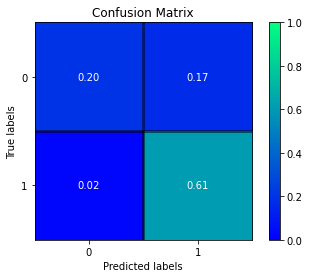

In [78]:
ptk.viz_confusion_matrix(learning_rate_matrix)

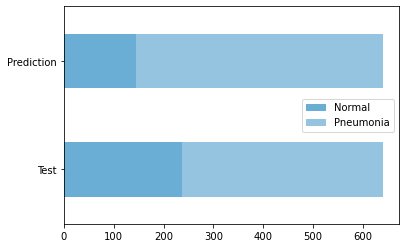

,Test,Prediction
Normal,237,144
Pneumonia,403,496


In [79]:
ptk.viz_class_balance_comparison(learning_rate_labels[0],learning_rate_labels[1])

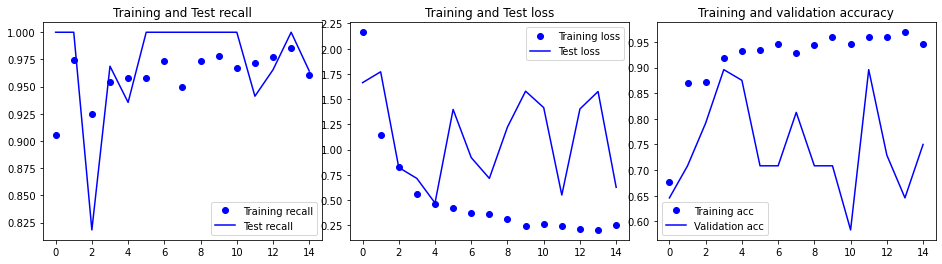

In [80]:
ptk.viz_training_history(learning_rate_model_results,recall_num="_12")

I've tested various lerning rates from 0.01 to 0.0001 and the trend seems the smaller the learning rate the less overfitting. A learning rate of 0.001 is the least oscillatory, and both recall and loss trend in the proper directions. So I will move on with the model as it is above with a learning rate of .003 (1e-3). 

## Final Model Selection
Below I am siply compiling and training a model identical to the one directly above, the only difference being the use a model checkpoint callback that saves the model as an .h5 file in the current working directory.

In [95]:
stopped_model = models.Sequential()

stopped_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
stopped_model.add(layers.MaxPooling2D((2, 2)))
stopped_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
stopped_model.add(layers.MaxPooling2D((2, 2)))
stopped_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
stopped_model.add(layers.MaxPooling2D((2, 2)))
stopped_model.add(layers.Flatten())
stopped_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.0005)))
stopped_model.add(layers.Dropout(0.05))
stopped_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
stopped_model.add(layers.Dropout(0.01))
stopped_model.add(layers.Dense(1, activation='sigmoid'))

lr = optimizers.Adam(learning_rate=1e-3)

stopped_model.compile(optimizer=lr,
                            loss='binary_crossentropy',
                            metrics=['acc',Recall()]
                            )


In [96]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = [ModelCheckpoint(filepath='final_model.h5',monitor='val_loss',save_best_only=True)]

stopped_model_results = stopped_model.fit(train_data_generator,
                                        callbacks=checkpoint,
                                        batch_size=16,
                                        steps_per_epoch=22, 
                                        epochs=15, 
                                        validation_data=test_data_generator, 
                                        validation_steps=3
                                        )

Epoch 1/15
22/22 [==============================] - 12s 523ms/step - loss: 2.1876 - acc: 0.7386 - recall_14: 0.9623 - val_loss: 1.7373 - val_acc: 0.6667 - val_recall_14: 1.0000
Epoch 2/15
22/22 [==============================] - 12s 529ms/step - loss: 1.3350 - acc: 0.7784 - recall_14: 0.9721 - val_loss: 1.2481 - val_acc: 0.7708 - val_recall_14: 0.9333
Epoch 3/15
22/22 [==============================] - 11s 521ms/step - loss: 0.8704 - acc: 0.8580 - recall_14: 0.9444 - val_loss: 0.8631 - val_acc: 0.7708 - val_recall_14: 0.9667
Epoch 4/15
22/22 [==============================] - 10s 476ms/step - loss: 0.5559 - acc: 0.9290 - recall_14: 0.9542 - val_loss: 1.0248 - val_acc: 0.6875 - val_recall_14: 0.9615
Epoch 5/15
22/22 [==============================] - 12s 538ms/step - loss: 0.4400 - acc: 0.9290 - recall_14: 0.9632 - val_loss: 0.6220 - val_acc: 0.8333 - val_recall_14: 1.0000
Epoch 6/15
22/22 [==============================] - 11s 522ms/step - loss: 0.3319 - acc: 0.9659 - recall_14: 0.9729

In [97]:
stopped_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 36992)           

In [98]:
stopped_kpi, stopped_report, stopped_matrix, stopped_labels = ptk.evaluate_model(stopped_model,test_data_generator)
print(stopped_report)

20/20 [==============================] - 3s 157ms/step - loss: 1.0338 - acc: 0.7344 - recall_14: 0.9975
Done!
              precision    recall  f1-score   support

         0.0       0.99      0.29      0.45       238
         1.0       0.70      1.00      0.83       402

    accuracy                           0.73       640
   macro avg       0.84      0.64      0.64       640
weighted avg       0.81      0.73      0.68       640



# Final Model QA
A final model has been selected and saved for portability and reusability. Below I am simply loading the model and ensuring its usability as well quickly evaluating it with the project toolkit functions used throughout this notebook.

In [103]:
from keras.models import load_model
saved_model =  load_model('final_model.h5')

In [104]:
results_train = saved_model.evaluate(train_data_generator)
print(f'Training Recall: {results_train[2]:.3} \nTraining Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(test_data_generator)
print(f'Test Recall: {results_test[2]:.3} \nTest Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

print('----------')

results_val = saved_model.evaluate(val_data_generator)
print(f'Validation Recall: {results_val[2]:.3} \nValidation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

326/326 [==============================] - 74s 228ms/step - loss: 0.3827 - acc: 0.9515 - recall_14: 0.9530
Training Recall: 0.953 
Training Loss: 0.383 
Training Accuracy: 0.951
----------
39/39 [==============================] - 8s 209ms/step - loss: 0.7325 - acc: 0.8013 - recall_14: 0.9692
Test Recall: 0.969 
Test Loss: 0.733 
Test Accuracy: 0.801
----------
1/1 [==============================] - 0s 2ms/step - loss: 0.6058 - acc: 0.8750 - recall_14: 0.8750
Validation Recall: 0.875 
Validation Loss: 0.606 
Validation Accuracy: 0.875


#### Final model diagnostics on test data

In [105]:
final_kpi, final_report, final_matrix, final_labels = ptk.evaluate_model(saved_model,test_data_generator)
print(final_report)

20/20 [==============================] - 6s 324ms/step - loss: 0.7295 - acc: 0.8016 - recall_14: 0.9701
Done!
              precision    recall  f1-score   support

         0.0       0.91      0.52      0.66       238
         1.0       0.77      0.97      0.86       402

    accuracy                           0.80       640
   macro avg       0.84      0.74      0.76       640
weighted avg       0.82      0.80      0.79       640



Test Data


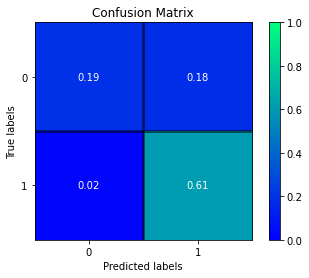

In [108]:
print("Test Data")
ptk.viz_confusion_matrix(final_matrix)

Test data


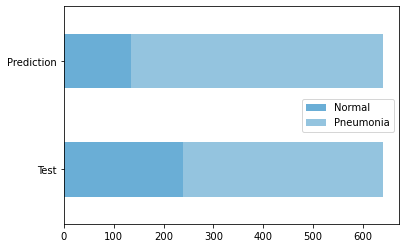

,Test,Prediction
Normal,238,135
Pneumonia,402,505


In [109]:
print("Test data")
ptk.viz_class_balance_comparison(final_labels[0],final_labels[1])

#### Final model diagnostics on validation data

In [111]:
val_kpi, val_report, val_matrix, val_labels = ptk.evaluate_model(saved_model,val_data_generator)
print(val_report)

1/1 [==============================] - 0s 2ms/step - loss: 0.6058 - acc: 0.8750 - recall_14: 0.8750
Done!
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88        16
         1.0       0.88      0.88      0.88        16

    accuracy                           0.88        32
   macro avg       0.88      0.88      0.88        32
weighted avg       0.88      0.88      0.88        32



In [121]:
from sklearn.metrics import confusion_matrix
y_test,y_pred = (val_labels[0][:16],val_labels[1][:16])

val_matrix = confusion_matrix(y_test,y_pred)


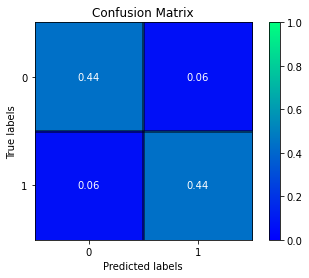

In [122]:
ptk.viz_confusion_matrix(val_matrix)

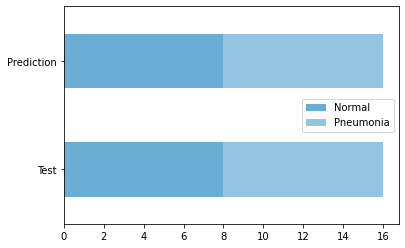

,Test,Prediction
Normal,8,8
Pneumonia,8,8


In [123]:
ptk.viz_class_balance_comparison(y_test,y_pred)

## Conclusions
The final model is saved succesfully and performs within the needs of its inteneded use. It has an improvable false positive rate, however it performs well enough that I am comfortable deploying it to beta testing in the real world with select medical offices and begin developing the software through which end users will utilize the tool. While the false positive rate is extant, the false negative rate is minuscule and the true positive rate is almost perfect; this is consistent with other classification methods and AI used for medical diagnostic purposes.
